# Open-Vocabulary Attention Maps (OVAM) - Getting Started

In [1]:
import torch
from diffusers import StableDiffusionPipeline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Import the OVAM library
from ovam import StableDiffusionHooker
from ovam.utils import set_seed, get_device
from ovam.optimize import optimize_embedding
from ovam.utils.dcrf import densecrf

/home/fstillger/miniconda3/envs/ovam/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load Stable Diffusion model from HuggingFace

In [2]:
model_id = "runwayml/stable-diffusion-v1-5"
device = get_device()

pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe = pipe.to(device)

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 15.58it/s]


In [3]:
pipe.set_progress_bar_config(disable=True)

## Evaluate OVAM with natural language

Generate an image with Stable Diffusion and store diffusion features for generating attention maps using the Hooker. This hooker catch all needed features related with the generation of cross-attention maps and store them for further generation.

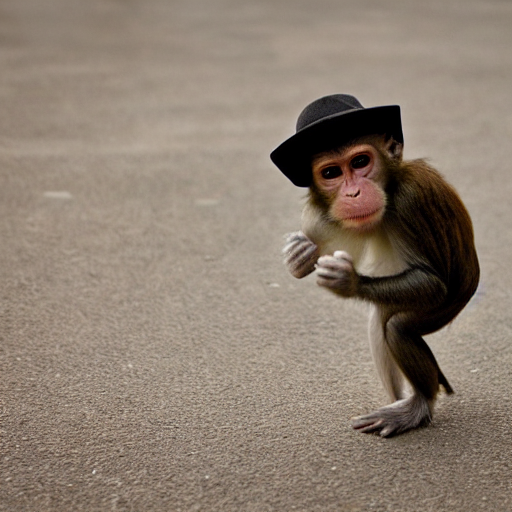

In [7]:
with StableDiffusionHooker(pipe) as hooker:
    set_seed(1234567)
    out = pipe(prompt="monkey with hat walking")
    image = out.images[0]

image

Generate attention maps using the Hooker. The method `get_ovam_callable` returns a torch module that can be used to generate attention maps for a given input (string or a tensor with a text embedding).

In [12]:
ovam_evaluator = hooker.get_ovam_callable(
    expand_size=(512, 512)
)  # Here you can configure the OVAM evaluator (aggregation, activations, size, ...)

with torch.no_grad():
    attention_maps = ovam_evaluator("monkey with hat walking and hand")
    attention_maps = attention_maps[0].cpu().numpy() # (8, 512, 512)

Plot using matplotlib.

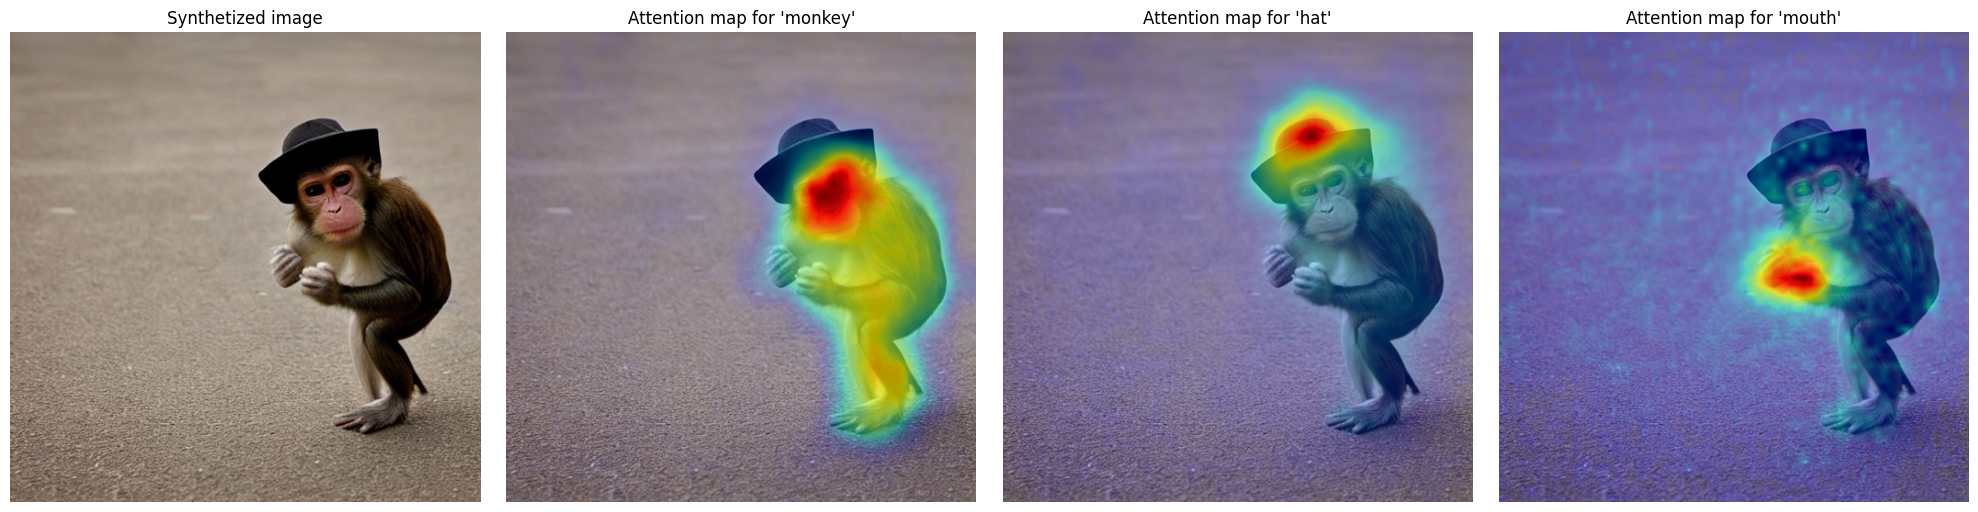

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax in axes:
    ax.axis("off")
    ax.imshow(image)

axes[0].set_title("Synthetized image")
# Tokens: 0:<SoT>, 1:monkey, 2:with, 3:hat, 4:walking, 5:and, 6:mouth, 7:<EoT>
axes[1].set_title("Attention map for 'monkey'")
monkey = attention_maps[1]
axes[1].imshow(monkey, alpha=monkey / monkey.max(), cmap='jet')
axes[2].set_title("Attention map for 'hat'")
hat = attention_maps[3]
axes[2].imshow(hat, alpha=hat / hat.max(), cmap='jet')
axes[3].set_title("Attention map for 'mouth'")
mouth = attention_maps[6]
axes[3].imshow(mouth, alpha=mouth / mouth.max(), cmap='jet')

# Adjust padding and save
fig.tight_layout()

## Token optimization

A token for a class can be optimized with just a single annotation. We generate and image and use an annotation of the cat. Note that for different systems the generated image may be different than the annotation.

In [ ]:
with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker:
    set_seed(123456)
    out = pipe(prompt="a photograph of a cat in a park")
    image = out.images[0]

# Load annotation of the cat
cat_annotation = Image.open("../docs/assets/cat_annotation.png")

# Plot using matplotlib
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7, 4))
ax0.imshow(image)
ax0.axis("off")
ax0.set_title("Synthetized image")
ax1.imshow(cat_annotation)
ax1.axis("off")
ax1.set_title("Cat annotation")
fig.tight_layout()


We use the target mask to optimize a token. Here X' is the input of a callable ovam(X') generates an attention map, and we optimize 

$$
\underset{X'}{argmin} \, \mathcal{L}(ovam(X'), Mask)
$$

using gradient descent and binary cross entropy loss.

In [ ]:
cat_target = (np.array(cat_annotation).sum(axis=-1) > 0).astype(
    np.float32
)  # (512, 512)
cat_target = torch.tensor(cat_target).to(device)
cat_target = torch.stack([1 - cat_target, cat_target], dim=0).unsqueeze(
    0
)  # (n_tokens=2, 512, 512)

# Get the OVAM evaluator
ovam_evaluator = hooker.get_ovam_callable(expand_size=(512, 512))

# Initalize a X' with <SoT> and "cat" tokens (2, 768)
embedding = ovam_evaluator.encode_text(
    text="cat",
    context_sentence="a photograph of a cat in a park",
    remove_special_tokens=False,
)[
    :-1
]  # This returns <Sot> + Cat + <Eot> tokens. Eot is removed.


# Optimize the embedding
embedding = optimize_embedding(
    ovam_evaluator,
    embedding=embedding, # Initial embedding
    target=cat_target, # Target mask
    device=device, # Device
)

Here we can check the result in the training image.

In [ ]:
with torch.no_grad():
    optimized_map = ovam_evaluator(embedding.to(device)).squeeze().cpu().numpy()[1] # (512, 512)
    non_optimized_map = ovam_evaluator("cat").squeeze().cpu().numpy()[1] # (512, 512)

# Plot result using
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(14, 4))
ax0.imshow(image)
ax0.axis("off")
ax0.set_title("Synthetized image")
ax1.set_title("Target mask")
ax1.imshow(cat_annotation)
ax1.axis("off")
ax2.set_title("Attention of word cat")
ax2.imshow(non_optimized_map)
ax2.axis('off')
ax3.set_title("Optimized attention for cat")
ax3.imshow(optimized_map)
ax3.axis('off')
fig.tight_layout()


In case you do not run the optimization, we can load the token X' from the file.

In [ ]:
embedding = np.load("../docs/assets/cat_optimized_token.npy") # Shape (2, 768)
embedding = torch.tensor(embedding).to(device)

Check the result in the training image.

In [ ]:
# Generate a new image
with StableDiffusionHooker(pipe) as hooker:
    set_seed(123456)
    out = pipe(prompt="cat perched on the sofa looking out of the window")
    image = out.images[0]

# Evaluate the attention map with the word cat and the optimized embedding
with torch.no_grad():
    ovam_evaluator = hooker.get_ovam_callable(expand_size=(512, 512))
    optimized_map = ovam_evaluator(embedding).squeeze().cpu().numpy()[1] # (512, 512)
    non_optimized_map = ovam_evaluator("cat").squeeze().cpu().numpy()[1] # (512, 512)

# Plot result using matplotlib
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(9, 4))
ax0.imshow(image)
ax0.axis("off")
ax0.set_title("Synthetized image")
ax1.set_title("Attention of word cat")
ax1.imshow(non_optimized_map)
ax1.axis('off')
ax2.set_title("Optimized attention for cat")
ax2.imshow(optimized_map)
ax2.axis('off')
fig.tight_layout()

## Mask binarization

Finally, we can binarize the attention map using a threshold and dCRF is used to improve the mask. Also, crf can take the probability map to avoid the decision of the threshold.

In [ ]:
binary_mask = densecrf(np.array(image), optimized_map / optimized_map.max())
binary_mask_05 = densecrf(np.array(image), (optimized_map / optimized_map.max()) > 0.5)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.set_title("Automatic threshold (dCRF)")
ax0.axis("off")
ax0.imshow(image)
ax0.imshow(binary_mask, alpha=binary_mask)
ax1.set_title("Threshold = 0.5")
ax1.axis("off")
ax1.imshow(image)
ax1.imshow(binary_mask_05, alpha=binary_mask_05)
plt.tight_layout()


## Self-Attention maps.

The Stable Diffusion Hooker can be used to store also the self-attention maps. Useful as a post-processing step to generate the binary masks.
Rerun  the image generation, but specify also store the self attention maps.

In [ ]:
with StableDiffusionHooker(pipe, extract_self_attentions=True) as hooker:
    set_seed(123456)
    out = pipe(prompt="monkey with hat walking")
    image = out.images[0]

With get_self_attention_map we can get a tensor with the self-attention. By default, all the self-attention maps are averaged, for all blocks and heads. This self-attention map is correlated with foreground objects. It can be used to improve the generation of binary masks by multiplying the attention map with the self-attention map.

In [ ]:
self_attention = hooker.get_self_attention_map(size=(512, 512)).cpu().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image)
ax1.axis("off")
ax1.set_title("Synthetized image")
ax2.imshow(self_attention)
ax2.axis("off")
ax2.set_title("Self-attention map resized (all blocks)")
fig.tight_layout()

By seeing the self-attentions per block, we can see how 16x16 do not use them, and 64 x 64 capture the finer details of the image layout

In [ ]:
self_attention_by_block = hooker.get_self_attention_map(stack=False)
n_blocks = len(self_attention_by_block)
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
axes = axes.flatten()
for block, ax in zip(self_attention_by_block, axes):
    block = block.cpu().numpy()
    ax.set_title(f"Block {block.shape}")
    ax.imshow(block)
    ax.axis("off")

plt.tight_layout()

## Use with multiple images

If multiple images are used, the hooker will store the attention maps for all of them. The ovam callable will return an attention with shape (batch_size, num_tokens, w, h). This is useful for optimize tokens with multiple images at the same time.

In [ ]:
with StableDiffusionHooker(pipe) as hooker:
    set_seed(123456)
    out1 = pipe(prompt="monkey with hat walking")
    out2 = pipe(prompt="an orangutan in a forest")

image1 = out1.images[0]
image2 = out2.images[0]

ovam_evaluator = hooker.get_ovam_callable(expand_size=(512, 512))
with torch.no_grad():
    attention_maps = ovam_evaluator("monkey").cpu().numpy() # Shape (n_images=2, n_tokens=3, 512, 512)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image1)
ax1.imshow(attention_maps[0][1], alpha=attention_maps[0][1] / attention_maps[0][1].max(), cmap='jet')
ax1.axis("off")



ax2.imshow(image2)
ax2.imshow(attention_maps[1][1], alpha=attention_maps[1][1] / attention_maps[1][1].max(), cmap='jet')
ax2.axis("off")
fig.tight_layout()